In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# If True, test is running on Colab. Otherwise, test if assumed to be offline.
TEST_ON_COLAB = True
# FOLDERNAME = 'cifar10'  # only used if TEST_ON_COLAB is True
FOLDERNAME = 'F-mnist'  # only used if TEST_ON_COLAB is True

assert not (FOLDERNAME is None and TEST_ON_COLAB), "FOLDERNAME has to be set if TEST_ON_COLAB is True"

# Atividade de programação 1 (AP1)
## Classificador softmax: 15 pontos

Responda as questões indicadas e preencha os campos indicados com o tag `TODO`.

### Parte I: Preparação dos dados

**1. (0,5 pontos)** Pesquise um dataset de classificação (duas ou mais classes) de sua preferência (exceto mnist) utilizando o site `https://openml.org/`. O download do dataset será realizado por meio da função `fetch_openml` da biblioteca `scikit-learn`. Para essa atividade, o dataset deve ter a mesma estrutura de dados e rótulos ($X$, $y$) vistos em exemplos de aula.

Dica: verifique datasets famosos em `https://medium.com/data-science-bootcamp/famous-machine-learning-datasets-you-need-to-know-dd031bf74dd`.

In [3]:
# TODO: Set the dataset ID #
# DATASET_OPENML_ID = 40927  # id do CIFAR100
DATASET_OPENML_ID = 40996  # id do FASHIONMnist
############################

assert DATASET_OPENML_ID is not None, "DATASET_OPENML_ID is not set"

Download do dataset:

In [4]:
# Create dataset directory

import os

if TEST_ON_COLAB:
    # This mounts your Google Drive to the Colab VM.
    from google.colab import drive

    drive.mount("/content/drive")
    cache_dir = f"/content/drive/My Drive/{FOLDERNAME}/dataset/{DATASET_OPENML_ID}"
else:
    cache_dir = f"dataset/{DATASET_OPENML_ID}"

os.makedirs(cache_dir, exist_ok=True)

# Fetching the dataset
from sklearn.datasets import fetch_openml
import numpy as np

X_file_path = f"{cache_dir}/X.npy"
y_file_path = f"{cache_dir}/y.npy"

# Check if the dataset files already exist
if not (os.path.exists(X_file_path) and os.path.exists(y_file_path)):
    # Fetch the dataset where X is the data and y is the target
    X, y = fetch_openml(data_id=DATASET_OPENML_ID, as_frame=False, cache=True, return_X_y=True)

    # Save the dataset as numpy arrays
    np.save(X_file_path, X.astype(np.float32))
    np.save(y_file_path, y)
    print(f"{DATASET_OPENML_ID} dataset downloaded and saved successfully to {cache_dir}.")
else:
    X = np.load(X_file_path, allow_pickle=True)
    y = np.load(y_file_path, allow_pickle=True)
    print(f"{DATASET_OPENML_ID} dataset already exists in {cache_dir}. Skipping download.")

print(X.shape)
print(X.min(), X.max())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
40996 dataset already exists in /content/drive/My Drive/F-mnist/dataset/40996. Skipping download.
(70000, 784)
0.0 255.0


**2. (1 ponto)** Calcule o número de classes do dataset com bases no vetor de rótulos $y$. Em seguida, calcule o número de features.

In [5]:
# TODO: Calculate the number of classes #
num_classes = len(np.unique(y))
print('Numero de classes: ', num_classes)
#########################################

# TODO: Calculate the number of features #
num_features = X.shape[1]
print('Numero de características: ', num_features)
##########################################

assert num_classes is not None, "num_classes is not set"
assert num_features is not None, "num_features is not set"

Numero de classes:  10
Numero de características:  784


Visualizando algumas amostras do dataset:

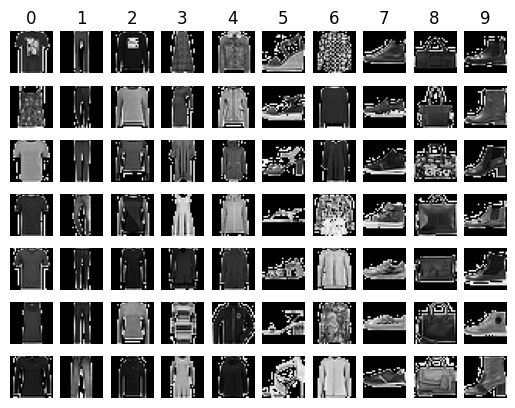

In [6]:
import matplotlib.pyplot as plt

# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = [int(class_id) for class_id in np.unique(y)]
samples_per_class = 7
for cls in classes:
    idxs = np.flatnonzero(y == str(cls))
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + cls + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        # plt.imshow((255 * X[idx, :-1]).reshape((28, -1)).astype('uint8'), cmap='gray')
        plt.imshow((255 * X[idx]).reshape((28, 28)).astype('uint8'), cmap='gray')
        # plt.imshow(X[idx].reshape((32, 32, 3)).astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

### Parte II: Implementação do classificador softmax

Nesta parte da atividade, abordaremos o processo de treinamento. Para isso, serão defindas algumas funções auxiliares:

In [7]:
def cross_entropy_loss(Y_pred, class_idxs):
    """Compute the cross-entropy loss for a batch of exemplars.

    Args:
        Y_pred: the predicted class probabilities.
        class_idxs: the indices of the true classes.
    """
    Y_pred = np.clip(Y_pred, 1e-12, 1.0 - 1e-12)  # previne log(0)
    losses = -np.log(Y_pred[range(len(class_idxs)), class_idxs])
    return np.mean(losses)


def cross_entropy_grad(Y_pred, class_idxs):
    """Compute the gradient of the cross-entropy loss wrt the predicted class probabilities (batch version).

    Args:
        Y_pred: the predicted class probabilities.
        class_idxs: the indices of the true classes.
    """
    Y_pred = np.clip(Y_pred, 1e-12, 1.0 - 1e-12) # previne /0
    grad = -1 / Y_pred[range(len(Y_pred)), class_idxs]  # n,
    grad_output = np.zeros_like(Y_pred)  # (n, k)
    grad_output[range(len(grad_output)), class_idxs] = grad  # (n, k)
    return grad_output  # (n, k)


def softmax_grad(grad_output, Y_pred):
    """Computer the gradient of the loss wrt the logits of the softmax function (batch version).

    Args:
        grad_output: the gradient of the loss wrt the output of the softmax.
        Y_pred: the output of the softmax function.
    """
    grad = np.zeros_like(grad_output)  # (n, k)
    for i in range(len(grad_output)):
        y_pred = Y_pred[i].reshape(-1, 1)  # (k, 1)
        J = np.dot(-y_pred, y_pred.T)  # (k, 1) * (1, k) => (k, k)
        J[np.diag_indices_from(J)] = y_pred.flatten() * (1 - y_pred.flatten())  # (k, k)
        grad[i] = np.dot(grad_output[i], J)  # (k,) @ (k, k) => (k,)
    return grad


def linear_gradW(grad_output, X):
    """Compute the gradient of the loss wrt the output of a linear layer (batch version).

    Args:
        grad_output: the gradient of the loss wrt the output of the linear layer.
        X: the input of the linear layer.

    Returns:
        the gradient of the loss wrt the weights of the linear layer.
    """
    grad = np.dot(X.T, grad_output)  # (d, n) @ (n, h) => (d, h)

    # average over the batch
    grad /= X.shape[0]
    return grad

def softmax(z):
    """Softmax function (batch version).

    Args:
        z: the input of the softmax function.

    Returns:
        the output of the softmax function (probabilities).
    """
    z -= np.max(z, axis=1, keepdims=True) # normalize
    return np.exp(z) / np.sum(np.exp(z), axis=1, keepdims=True)

#### Treinamento do modelo: versão I

**3. (1,5 ponto)** Nesta primeira versão, os dados serão particionados em treino e teste apenas. Utilize a função `train_test_split` do módulo `sklearn.model_selection` para dividir o conjunto de dados (`X` e `y`), sendo 90% do total reservado para o treinamento e 10% para teste.

Encontre o maior valor nos dados de treinamento e divida todos os valores (treinamento e teste) pelo maior valor encontrado. Em seguida, adicione uma coluna de 1's no vetor de atributos de treinamento e teste.

In [8]:
from sklearn.model_selection import train_test_split

# Set the random seed for reproducibility
SEED = 42
np.random.seed(SEED)

# Convert labels from string to integer
y = y.astype(int)

# TODO: Split the dataset into train, validation, and test sets #
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=SEED)
#################################################################

assert X_train is not None, "X_train is not set"
assert y_train is not None, "y_train is not set"
assert X_test is not None, "X_test is not set"
assert y_test is not None, "y_test is not set"

# TODO: Normalize the data ###
max_value = X_train.max()
X_train = X_train / max_value
X_test = X_test / max_value
##############################

assert max_value is not None, "max_value is not set"
assert X_train.min() == 0.0 and X_train.max() == 1.0, "X_train is not normalized"
assert X_test.min() == 0.0 and X_test.max() == 1.0, "X_test is not normalized"

# TODO: Add bias to the data #
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
##############################

assert X_train.shape[1] == num_features + 1, "X_train does not have the correct shape"
assert X_test.shape[1] == num_features + 1, "X_test does not have the correct shape"

print(f"Train set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Train set size: 63000
Test set size: 7000


**4. (3 pontos)** Nesta questão, você deve completar os espaços indicados de modo a implementar o processo de treinamento de um classificador softmax para $k$ classes:

$$
\hat{\mathbf{y}} = \text{softmax}(\mathbf{W}^T \mathbf{x}),
$$

onde $\mathbf{W} \in \mathbb{R}^{(d+1) \times k}$ é a matriz de pesos do classificador, $\mathbf{x} \in \mathbb{R}^{(d+1)}$ é o vetor de entrada e $\hat{\mathbf{y}} \in \mathbb{R}^{k}$ é a predição do classificador (assumimos que $\mathbf{x}$ e $\hat{\mathbf{y}}$ são vetores coluna).

Para *mini-batch gradient descent*, as predições são calculadas como

$$
\hat{\mathbf{Y}} = \text{softmax}(\mathbf{X}\mathbf{W}),
$$

onde $\mathbf{X} \in \mathbb{R}^{n \times (d+1)}$ é a matriz de dados e $\hat{\mathbf{Y}} \in \mathbb{R}^{n \times k}$ é a matriz de predições.

In [9]:
from tqdm.notebook import tqdm

np.random.seed(SEED)

# TODO: Set learning rate #
learning_rate = 0.01
###########################

assert learning_rate is not None, "learning_rate is not set"

# Batch size
batch_size = 256 # adjust as needed

# Number of epochs
num_epochs = 100

# Initialize weights
W = np.random.normal(size=(X_train.shape[1], num_classes)) * 0.001

# Initialize iteration
iteration = 0
loss_history = []

# Training loop
pbar = tqdm(total=num_epochs, desc="")
for epoch in range(num_epochs):
    # Loop over batches
    for k in range(0, X_train.shape[0], batch_size):
        X_batch = X_train[k:k+batch_size]
        y_batch = y_train[k:k+batch_size]

        # TODO: Forward pass (compute class probabilities) #
        z = np.dot(X_batch, W)  # z = XW
        Y_pred = softmax(z)
        ####################################################

        assert Y_pred is not None, "Y_pred is not set"

        # TODO: Compute loss #
        loss = cross_entropy_loss(Y_pred, y_batch)
        ######################

        assert loss is not None, "loss is not set"

        # Save the loss
        loss_history.append(loss)

        # TODO: Backward pass (compute gradients) #
        grad_pred = cross_entropy_grad(Y_pred, y_batch)
        grad_z = softmax_grad(grad_pred, Y_pred)
        grad_W = np.dot(X_batch.T, grad_z)
        ###########################################

        assert grad_pred is not None, "grad_pred is not set"
        assert grad_z is not None, "grad_z is not set"
        assert grad_W is not None, "grad_W is not set"

        # TODO: Update weights ################################
        W -= learning_rate * grad_W
        #######################################################

        assert W is not None, "W is not set"

        iteration += 1

        if iteration % 100 == 0:
            pbar.set_description(f"Epoch loss: {loss:.3f}")

    # Update progress bar
    pbar.update(1)

  0%|          | 0/100 [00:00<?, ?it/s]

Confira a curva de aprendizado do modelo:

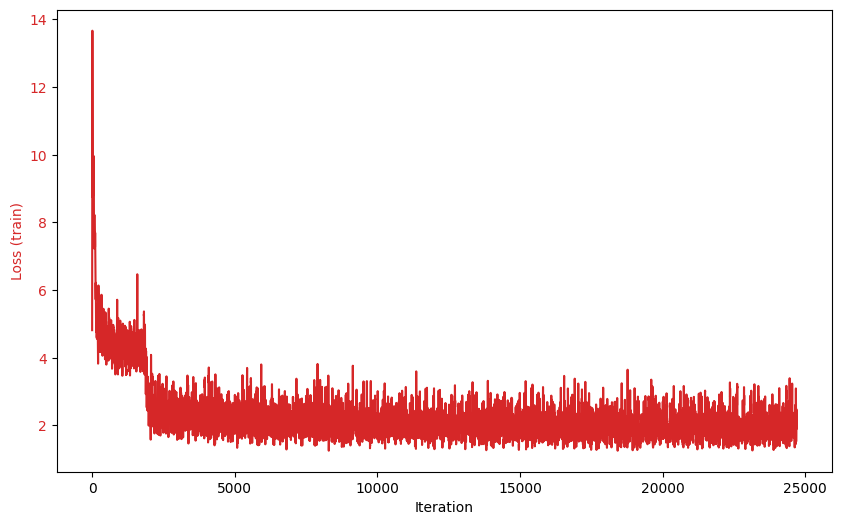

In [10]:
def smooth_loss_history(loss_history, window_size=10):
    """ Smooth the loss history for better visualization.

    Args:
        loss_history (numpy.ndarray): The loss history.

    Returns:
        numpy.ndarray: The smoothed loss history.
    """
    kernel = np.ones(window_size) / window_size
    smoothed_loss_history = np.convolve(loss_history, kernel, mode="same")
    return smoothed_loss_history

fig, ax1 = plt.subplots(figsize=(10, 6))

color = "tab:red"
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Loss (train)", color=color)
ax1.plot(smooth_loss_history(loss_history), color=color)
ax1.tick_params(axis="y", labelcolor=color)
plt.show()

#### Resultados (inferência)

**5. (1 ponto)** Realize as inferências finais no conjunto de teste preenchendo a célula abaixo. Visualize o resultado do teste.

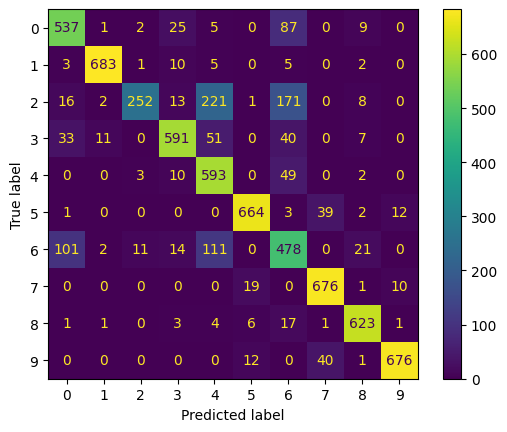


Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.81      0.79       666
           1       0.98      0.96      0.97       709
           2       0.94      0.37      0.53       684
           3       0.89      0.81      0.84       733
           4       0.60      0.90      0.72       657
           5       0.95      0.92      0.93       721
           6       0.56      0.65      0.60       738
           7       0.89      0.96      0.92       706
           8       0.92      0.95      0.93       657
           9       0.97      0.93      0.95       729

    accuracy                           0.82      7000
   macro avg       0.85      0.82      0.82      7000
weighted avg       0.85      0.82      0.82      7000



In [11]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# TODO: Predict classes on test set #
z_test = np.dot(X_test, W)
Y_pred_test = softmax(z_test)
y_pred = np.argmax(Y_pred_test, axis=1)
#####################################

assert y_pred is not None, "y_pred is not set"

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred, labels=[class_id for class_id in range(10)])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[class_id for class_id in range(10)])
disp.plot()
plt.show()

# Compute classification report
class_report = classification_report(y_test, y_pred, target_names=[str(class_id) for class_id in range(10)])

print("\nClassification Report:")
print(class_report)

**6. (2 pontos)** Nesta segunda versão, os dados serão particionados em treino, validação e teste. Utilize a função `train_test_split` do módulo `sklearn.model_selection` para subdividir o conjunto de treinamento previamente determinado em treinamento (90%) e validação (10%).

In [12]:
# TODO: Split the train dataset into train and validation #
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
###########################################################

assert X_train is not None, "X_train is not set"
assert y_train is not None, "y_train is not set"
assert X_val is not None, "X_val is not set"
assert y_val is not None, "y_val is not set"

print(f"Train set size: {len(X_train)}")
print(f"Val set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Train set size: 56700
Val set size: 6300
Test set size: 7000


**7. (6 pontos)** Agora, você deve implementar o processo de treinamento utilizando a partição validação para determinar a o melhor modelo considerando cada época de treinamento (`best-epoch model`). A mesma configuração de treinamento da versão I deve ser utilizada, mas agora com a partição de validação.

In [13]:
np.random.seed(42)


# Initialize weights
W = np.random.normal(size=(X_train.shape[1], num_classes)) * 0.001

# Initialize best accuracy, weights, and epoch
best_accuracy = -1
best_W = None
best_epoch = 0
accuracy_val = -1

# Initialize iteration
iteration = 0

# Initialize history
loss_history = []
accuracy_history = []

# Training loop
pbar = tqdm(total=num_epochs, desc="")
for epoch in range(num_epochs):
    # Loop over batches
    for k in range(0, X_train.shape[0], batch_size):
        X_batch = X_train[k:k+batch_size]
        y_batch = y_train[k:k+batch_size]

        # Forward pass (compute class probabilities)
        z = np.dot(X_batch, W)
        Y_pred = softmax(z)

        assert Y_pred is not None, "Y_pred is not set"

        # Compute loss
        loss = cross_entropy_loss(Y_pred, y_batch)
        assert loss is not None, "loss is not set"

        # Save the loss
        loss_history.append(loss)

        # Backward pass (compute gradients)
        grad_pred = cross_entropy_grad(Y_pred, y_batch)
        grad_z = softmax_grad(grad_pred, Y_pred)
        grad_W = np.dot(X_batch.T, grad_z)
        assert grad_pred is not None, "grad_pred is not set"
        assert grad_z is not None, "grad_z is not set"
        assert grad_W is not None, "grad_W is not set"

        # Update weights
        W -= learning_rate * grad_W
        assert W is not None, "W is not set"

        iteration += 1
        if iteration % 100 == 0:
            pbar.set_description(
                f"Epoch loss: {loss:.3f} Accuracy (val): {accuracy_val:.3f} (best: {best_accuracy:.3f})"
            )

    # Predict classes on validation set
    z_val = np.dot(X_val, W)
    Y_pred_val = softmax(z_val)
    pred_labels_val = np.argmax(Y_pred_val, axis=1)

    # Compute accuracy on validation set
    accuracy_val = np.mean(pred_labels_val == y_val)
    assert Y_pred_val is not None, "Y_pred is not set"
    assert pred_labels_val is not None, "pred_labels is not set"
    assert accuracy_val is not None, "accuracy_val is not set"

    # Save the accuracy
    accuracy_history.append(accuracy_val)

    if accuracy_val > best_accuracy:
        best_accuracy = accuracy_val
        best_W = W.copy()
        best_epoch = epoch

    # Update progress bar
    pbar.update(1)

# Reset weights to the best found
W = best_W

# Informações finais
print(f"Best model found at epoch {best_epoch} with validation accuracy {best_accuracy:.4f}")


  0%|          | 0/100 [00:00<?, ?it/s]

Best model found at epoch 86 with validation accuracy 0.8394


Confira a curva de aprendizado do modelo:

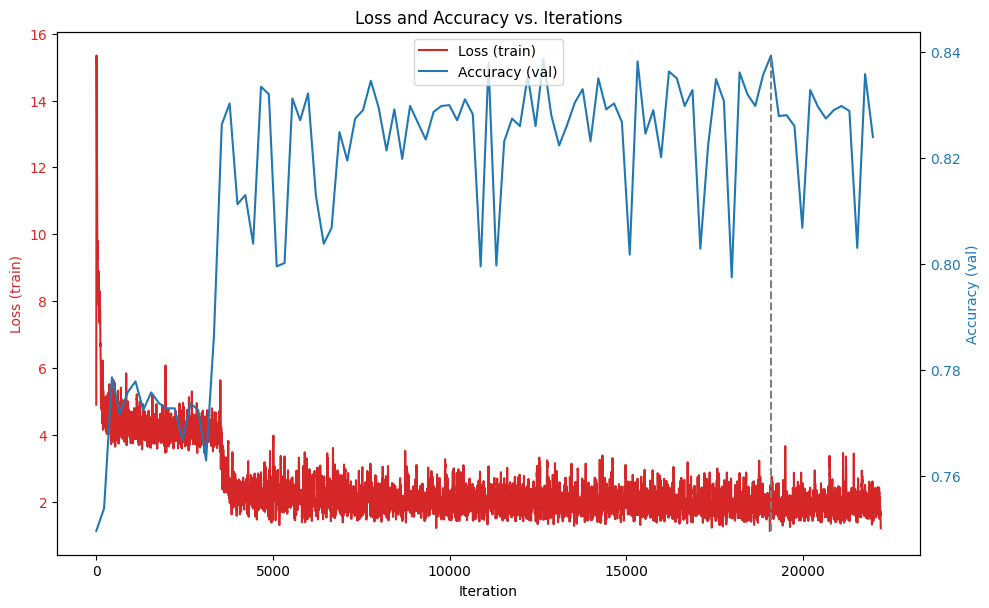

In [14]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Loss
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Loss (train)", color="tab:red")
handle1 = ax1.plot(smooth_loss_history(loss_history), color="tab:red", label="Loss (train)")
ax1.tick_params(axis="y", labelcolor="tab:red")

# Accuracy
ax2 = ax1.twinx()
ax2.set_ylabel("Accuracy (val)", color="tab:blue")
iterations_by_epoch = len(loss_history) // num_epochs
handle2 = ax2.plot(np.arange(0, len(loss_history), iterations_by_epoch), accuracy_history, color="tab:blue", label="Accuracy (val)")
ax2.tick_params(axis="y", labelcolor="tab:blue")
ax2.vlines(
    best_epoch * iterations_by_epoch, min(accuracy_history), max(accuracy_history), colors="gray", linestyles="dashed"
)
fig.tight_layout()

# Legend and title
handles = [handle1[0], handle2[0]]
plt.legend(handles, ["Loss (train)", "Accuracy (val)"], loc="upper center")
plt.title("Loss and Accuracy vs. Iterations")

plt.show()

#### Resultados (inferência)

Realize as inferências no conjunto de teste de acordo com o teste da primeira versão.

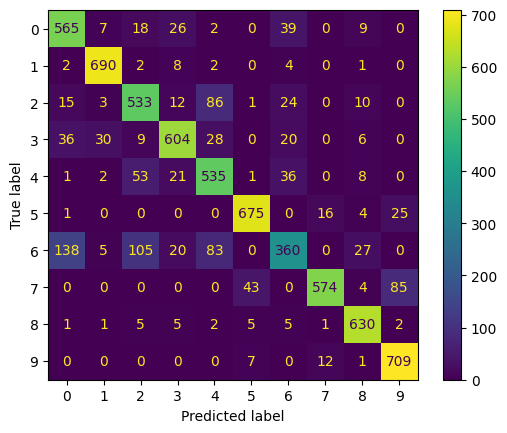


Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.85      0.79       666
           1       0.93      0.97      0.95       709
           2       0.74      0.78      0.76       684
           3       0.87      0.82      0.85       733
           4       0.72      0.81      0.77       657
           5       0.92      0.94      0.93       721
           6       0.74      0.49      0.59       738
           7       0.95      0.81      0.88       706
           8       0.90      0.96      0.93       657
           9       0.86      0.97      0.91       729

    accuracy                           0.84      7000
   macro avg       0.84      0.84      0.84      7000
weighted avg       0.84      0.84      0.83      7000



In [15]:
# TODO: Predict classes on test set ###################
z_test = np.dot(X_test, W)
Y_pred_test = softmax(z_test)
y_pred = np.argmax(Y_pred_test, axis=1)
#######################################################

assert y_pred is not None, "y_pred is not set"

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred, labels=[class_id for class_id in range(10)])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[class_id for class_id in range(10)])
disp.plot()
plt.show()

# Compute classification report
class_report = classification_report(y_test, y_pred, target_names=[str(class_id) for class_id in range(10)])

print("\nClassification Report:")
print(class_report)